# Casimir Athena

[Athena](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena.html) integrated data environment and query sandbox

## Table of Contents

* [Install Packages](#install-packages)
* [Configure Athena](#configure-athena)
* [Sample Usage](#sample-usage)

### Install Packages

The primary package is pyathena, which is a Python library for querying Amazon Athena that abstracts result-retrieval, and we use it to return a pandas dataframe for easy handling and further analysis.

In [280]:
# Interact with AWS credentials and environment overrides
import os
from dotenv import load_dotenv
import boto3
import boto3.session

# Query Athena
from pyathena import connect

# Handle results
import warnings
import pandas as pd
from matplotlib import plt
from matplotlib.dates import DateFormatter

ImportError: cannot import name 'plt' from 'matplotlib' (/Users/shane/Library/Caches/pypoetry/virtualenvs/data-qNpBeqxv-py3.8/lib/python3.8/site-packages/matplotlib/__init__.py)

### Configure Athena

We use the AWS credentials from your configured AWS profile (default `consensus-networks-dev`) to initialize the pyathena connection and define a DB query method.

In [ ]:
load_dotenv()
PROFILE=os.getenv('PROFILE')
profile = PROFILE or 'consensus-networks-dev'
session = boto3.Session(profile_name=profile)
creds = session.get_credentials()

connection = connect(
    aws_access_key_id=creds.access_key, 
    aws_secret_access_key=creds.secret_key, 
    s3_staging_dir="s3://casimir-etl-output-bucket-dev/", 
    region_name="us-east-2"
)

def db_query(sql_query: str) -> pd.DataFrame:
    """Execute SQL Query and get pandas dataframe"""
    with warnings.catch_warnings():
        # Ignore warning for non-SQLAlchemy connecton
        warnings.simplefilter('ignore', UserWarning)
        df = pd.read_sql_query(sql_query, connection)
    return df

> 🚩 You can override the default profile name by setting PROFILE in your project root `.env` file. See [Environment](../../../README.md#environment) for more information.

### Sample Usage: Stake Volume

Get daily new stake volume of a given candidate for the month of August in 2021.

           Day  Candidate     Amount
0   2021-08-01  coingecko  113301.00
1   2021-08-11  coingecko    1300.00
2   2021-08-13  coingecko    1408.00
3   2021-08-14  coingecko    5000.00
4   2021-08-15  coingecko  500000.00
5   2021-08-17  coingecko    2268.00
6   2021-08-18  coingecko    6052.00
7   2021-08-19  coingecko     100.00
8   2021-08-20  coingecko     200.00
9   2021-08-22  coingecko   22229.00
10  2021-08-23  coingecko   38682.87
11  2021-08-25  coingecko    9903.00
12  2021-08-26  coingecko     200.00
13  2021-08-27  coingecko    5113.00
14  2021-08-28  coingecko     180.00


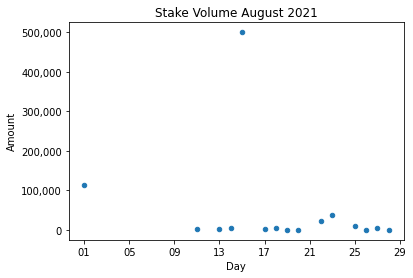

In [ ]:
query = """
        SELECT 
                date_trunc('day', datestring) as Day, 
                staked_candidate as Candidate,
                SUM(CAST(staked_amount AS double) / power(10, 18)) AS Amount
        FROM 
                casimir_etl_database_dev.casimir_etl_event_table_dev
        WHERE 
                staked_candidate = 'coingecko' 
        AND 
                type = 'create_stake' 
        AND 
                date_trunc('day', datestring) BETWEEN date '2021-08-01' AND date '2021-08-31'
        GROUP BY 
                date_trunc('day', datestring), 
                staked_candidate
        ORDER BY 
                date_trunc('day', datestring)
        """
        
dataframe = db_query(query)
print(dataframe)
ax=dataframe.plot.scatter(title='Stake Volume August 2021', x='Day', y='Amount', colormap='viridis', legend=True)
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))